In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
data = pd.read_csv("/content/data (1).csv")

In [9]:
data.groupby(['polygon']="Окт ДМ")
data

,polygon,id,subpolygon,stating_type,date_list,mileage_list,date_telematics,mileage_telematics,penalty,driving_style
0,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-01 00:00:00,158.0,2024-04-01 00:00:00,140.26,17.0,3.5
1,NaN,NaN,NaN,NaN,2024-04-04 00:00:00,9.0,2024-04-02 00:00:00,3.00,1.0,NaN
2,NaN,NaN,NaN,NaN,2024-04-08 00:00:00,5.0,2024-04-08 00:00:00,5.00,1.0,NaN
3,NaN,NaN,NaN,NaN,2024-04-09 00:00:00,7.0,2024-04-09 00:00:00,7.00,NaN,NaN
4,NaN,NaN,NaN,NaN,2024-04-10 00:00:00,12.0,2024-04-10 00:00:00,12.00,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
4414,NaN,NaN,NaN,NaN,2024-04-28 00:00:00,8.0,2024-04-28 00:00:00,8.00,NaN,NaN
4415,NaN,NaN,NaN,NaN,2024-04-30 00:00:00,46.0,2024-04-30 00:00:00,46.00,NaN,NaN
4416,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,NaN,11.0,NaN,0.00,0.0,5.3
4417,NaN,NaN,NaN,NaN,2024-04-05 00:00:00,3.0,NaN,NaN,9.0,3.2


In [10]:
df = pd.read_excel("data.xlsx")

In [11]:
df

,polygon,id,subpolygon,stating_type,date_list,mileage_list,date_telematics,mileage_telematics,penalty,driving_style
0,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-01,158.0,2024-04-01,140.26,17.0,3.5
1,NaN,NaN,NaN,NaN,2024-04-04,9.0,2024-04-02,3.00,1.0,NaN
2,NaN,NaN,NaN,NaN,2024-04-08,5.0,2024-04-08,5.00,1.0,NaN
3,NaN,NaN,NaN,NaN,2024-04-09,7.0,2024-04-09,7.00,NaN,NaN
4,NaN,NaN,NaN,NaN,2024-04-10,12.0,2024-04-10,12.00,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
4396,NaN,NaN,NaN,NaN,2024-04-28,8.0,2024-04-28,8.00,NaN,NaN
4397,NaN,NaN,NaN,NaN,2024-04-30,46.0,2024-04-30,46.00,NaN,NaN
4398,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,NaT,11.0,NaT,0.00,0.0,5.3
4399,NaN,NaN,NaN,NaN,2024-04-05,3.0,NaT,NaN,9.0,3.2


In [ ]:
for i in df:
  if df['mileage_list'] == 0 and df['mileage_telematics'] == 0:


In [48]:
df['penalty'] = df['penalty'].fillna(1)
if (df['penalty'] == 0).any():
    df['penalty'] == 1

df['penalty']

0       17.0
1        1.0
2        1.0
3        1.0
4        2.0
        ... 
4396     1.0
4397     1.0
4398     1.0
4399     9.0
4400     1.0
Name: penalty, Length: 4401, dtype: float64

# Графики по штрафам и манере вождения

In [58]:
mileage_polygons = df[~df.polygon.isna()].groupby('polygon')[['penalty', 'driving_style']].sum()
mileage_polygons['sum_driving_style'] = df[~df.polygon.isna()].groupby('polygon')[['penalty']].count()['penalty'].values * 6
mileage_polygons['cnt_penalty'] = df[~df.polygon.isna()].groupby('polygon')[['penalty']].count()['penalty'].values
mileage_polygons['res_drive_driving'] =  mileage_polygons['driving_style'] / mileage_polygons['sum_driving_style']
mileage_polygons['res_drive_penalty'] =  mileage_polygons['cnt_penalty'] / mileage_polygons['driving_style']
mileage_polygons = mileage_polygons.reset_index()
mileage_polygons

,polygon,penalty,driving_style,sum_driving_style,cnt_penalty,res_drive_driving,res_drive_penalty
0,Горьковская дир,676.0,533.8,828,138,0.644686,0.258524
1,Клнг. ДУТСК,139.0,115.1,192,32,0.599479,0.278019
2,Московская ДМ,733.0,488.0,882,147,0.553288,0.301230
3,Окт ДМ,389.0,293.2,486,81,0.603292,0.276262
4,Северная ДМ,418.0,334.4,468,78,0.714530,0.233254


## Манера вождения

In [1]:
graph1 = pd.DataFrame({'polygon': mileage_polygons['polygon'], 'res_drive_driving': mileage_polygons['res_drive_driving']})
graph1_sorted = graph1.sort_values(by='res_drive_driving', ascending=False)
graph1_sorted

NameError: name 'pd' is not defined

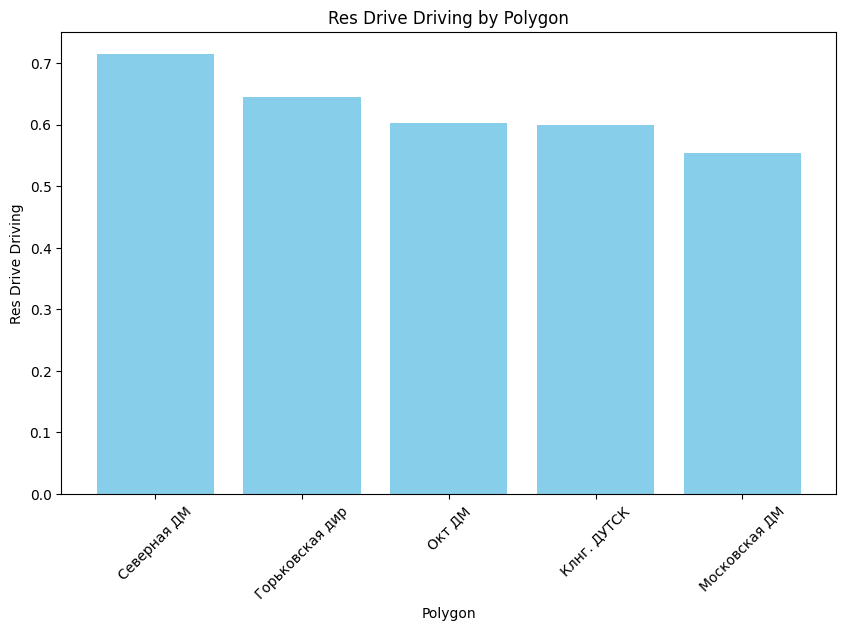

In [79]:
graph1 = pd.DataFrame({'polygon': mileage_polygons['polygon'], 'res_drive_driving': mileage_polygons['res_drive_driving']})
graph1_sorted = graph1.sort_values(by='res_drive_driving', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['res_drive_driving'], color='skyblue')
plt.xlabel('Polygon')
plt.ylabel('Res Drive Driving')
plt.title('Res Drive Driving by Polygon')
plt.xticks(rotation=45)
plt.show()

## Штрафы

In [98]:
graph1 = pd.DataFrame({'polygon': mileage_polygons['polygon'], 'res_drive_penalty': mileage_polygons['res_drive_penalty']})
graph1_sorted = graph1.sort_values(by='res_drive_penalty')
graph1_sorted['k_drive_penalty'] = graph1_sorted['res_drive_penalty'].apply(lambda x: 0.2 if x < 0.26 else 0.1)
mileage_polygons['k_drive_penalty'] = graph1_sorted['k_drive_penalty']

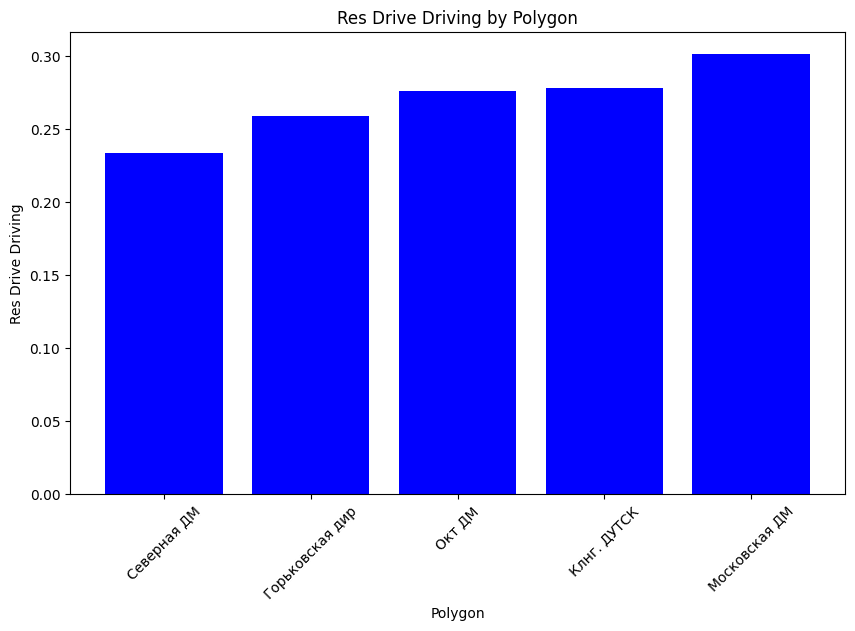

In [91]:
plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['res_drive_penalty'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Res Drive Driving')
plt.title('Res Drive Driving by Polygon')
plt.xticks(rotation=45)
plt.show()

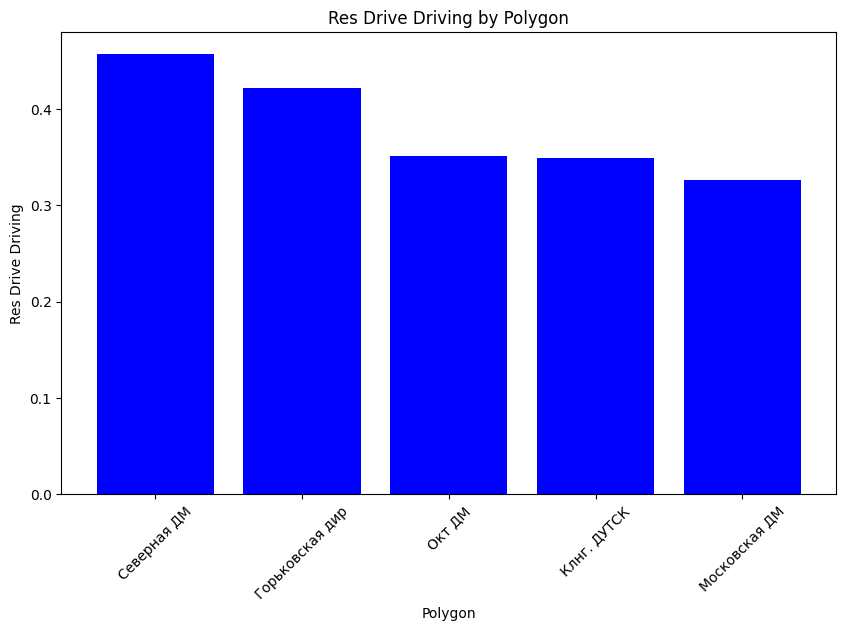

In [101]:
res = pd.DataFrame({'polygon': mileage_polygons['polygon'], 'res': mileage_polygons['res_drive_driving'] * 0.5 + mileage_polygons['k_drive_penalty'] * 0.5})
res_sorted = res.sort_values(by='res', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(res_sorted['polygon'], res_sorted['res'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Res Drive Driving')
plt.title('Res Drive Driving by Polygon')
plt.xticks(rotation=45)
plt.show()